# Disciplina de Aprendizado de Máquina não supervisionado

## Aula 05

### Parte I: *Clusterização* de dados categóricos

Até o momento vínhamos estudando algoritmos de clusterização aplicados a *toy data sets*, i.e., conjuntos de dados criados por nós, usando funções existentes na biblioteca `scikit-learn` para a geração de dados aleatórios com certas características estruturais. Eles são importantes para o aprendizado e para a avaliação ou compreensão do funcionamento dos diferentes algoritmos e seus resultados e aplicações. Mas todos eles eram constituídos de dimensões com variáveis numéricas contínuas.

No entanto, *data sets* mais realísticos também podem apresentar dimensões com dados categóricos nominais ou ordinais, além de quantitativos discretos. Na prática, teremos uma mistura de vários tipos.

Em nosso último encontro, vimos o trecho de código seguinte, que carrega um subconjunto de dados do enem de 2014, sendo composto de variáveis quantitativas e qualitativas.

In [112]:
# instalação de bibiotecas necessárias
!pip install kneed joypy scikit-learn-extra fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import pandas as pd
import requests
import io

uri = 'http://raw.githubusercontent.com/lwives/mlp/master/2014.csv'
content = requests.get(uri).content
df_enem = pd.read_csv(io.StringIO(content.decode('utf-8')), sep=";",usecols=["ano_fim_2g","co_uf_curso", "nu_idade", "tp_sexo", "nt_ger"])

df_enem.head() # mostra os 5 primeiros registros carregados no dataframe

,co_uf_curso,nu_idade,tp_sexo,ano_fim_2g,nt_ger
0,51,23,M,2007,66.9
1,51,24,M,2007,52.7
2,51,22,F,2009,58.2
3,51,24,F,2007,62.0
4,51,23,F,2008,71.5


Primeiro, vamos identificar o tipo das variáveis lidas, para avaliar se estão corretos:

In [114]:
# ilustra os tipos das variáveis lidas (conforme identificados automaticamente pela linguagem)
df_enem.dtypes

co_uf_curso      int64
nu_idade         int64
tp_sexo         object
ano_fim_2g       int64
nt_ger         float64
dtype: object

Podemos perceber que a linguagem não identificou corretamente o tipo de algumas delas. Com isso, algumas análises estatísticas podem ser inapropriadas. 

Veja:

In [115]:
# mostra informações estatísticas
df_enem.describe()

,co_uf_curso,nu_idade,ano_fim_2g,nt_ger
count,191.000000,191.000000,191.000000,191.000000
mean,46.167539,24.246073,2007.073298,54.438743
std,12.111030,3.584642,3.331646,12.278225
min,13.000000,21.000000,1980.000000,16.700000
25%,51.000000,23.000000,2007.000000,47.250000
50%,53.000000,24.000000,2008.000000,55.500000
75%,53.000000,25.000000,2009.000000,63.350000
max,53.000000,51.000000,2011.000000,79.600000


 Podemos mudar isso, através do seguinte procedimento:

In [116]:
df_enem["co_uf_curso"] = df_enem["co_uf_curso"].astype("category")
df_enem["tp_sexo"] = df_enem["tp_sexo"].astype("category")
df_enem.dtypes

co_uf_curso    category
nu_idade          int64
tp_sexo        category
ano_fim_2g        int64
nt_ger          float64
dtype: object

In [117]:
# mostra informações estatísticas
df_enem.describe()

,nu_idade,ano_fim_2g,nt_ger
count,191.000000,191.000000,191.000000
mean,24.246073,2007.073298,54.438743
std,3.584642,3.331646,12.278225
min,21.000000,1980.000000,16.700000
25%,23.000000,2007.000000,47.250000
50%,24.000000,2008.000000,55.500000
75%,25.000000,2009.000000,63.350000
max,51.000000,2011.000000,79.600000


In [118]:
df_enem.describe(include="all") # inclui as categóricas (agora corretamente ajustadas)

,co_uf_curso,nu_idade,tp_sexo,ano_fim_2g,nt_ger
count,191.0,191.000000,191,191.000000,191.000000
unique,4.0,NaN,2,NaN,NaN
top,53.0,NaN,F,NaN,NaN
freq,108.0,NaN,133,NaN,NaN
mean,NaN,24.246073,NaN,2007.073298,54.438743
std,NaN,3.584642,NaN,3.331646,12.278225
min,NaN,21.000000,NaN,1980.000000,16.700000
25%,NaN,23.000000,NaN,2007.000000,47.250000
50%,NaN,24.000000,NaN,2008.000000,55.500000
75%,NaN,25.000000,NaN,2009.000000,63.350000


In [119]:
# mostra novamente o dataframe (em termos visuais, não houve mudança)
df_enem.head() # mostra os 5 primeiros registros carregados no dataframe

,co_uf_curso,nu_idade,tp_sexo,ano_fim_2g,nt_ger
0,51,23,M,2007,66.9
1,51,24,M,2007,52.7
2,51,22,F,2009,58.2
3,51,24,F,2007,62.0
4,51,23,F,2008,71.5


Agora que já temos as variáveis corretamente configuradas, como podemos aplicar o processo de *clusterização*? 

Lembre-se de que os algoritmos que estudamos até o momento são preparados para dados quantitativos contínuos!

Uma abordagem simplista envolve recodificar as variáveis categóricas, criando novas dimensões específicas (binárias) para seus valores. Essa técnica é conhecida por [`One-hot`](https://en.wikipedia.org/wiki/One-hot) e é implementada pela função `get_dummies()`, que cria variáveis `dummy` que assumem valores `0` ou `1` para indicar respectivamente a absência ou presença de algum efeito categórico:

In [120]:
pd.get_dummies(df_enem, columns=["tp_sexo"]).head()

,co_uf_curso,nu_idade,ano_fim_2g,nt_ger,tp_sexo_F,tp_sexo_M
0,51,23,2007,66.9,0,1
1,51,24,2007,52.7,0,1
2,51,22,2009,58.2,1,0
3,51,24,2007,62.0,1,0
4,51,23,2008,71.5,1,0


**Exercício 1**: Observe o seguinte trecho de código que cria um *data set* fictício com diferentes tipos de variáveis. Perceba que o trecho tenta utilizar o método `get_dummies()` para aplicar a técnica `one-hot` com o objetivo de ajustar as variáveis categóricas. No entanto, ele não funciona conforme o esperado, aplicando a todas as variáveis da base.

Ajuste o código de maneira a fazer com que a aplicação funcione corretamente (i.e., só nas variáveis categóricas).

In [121]:
import pandas as pd

dados = { 
    'Nome'  : ['José', 'Renato', 'Ana', 'Laura', 'Priscila', 'Rodrigo', 'Paula', 'Leonardo', 'José', 'Carla'],
    'Olhos' : ['castanhos', 'castanhos', 'castanhos', 'azuis', 'verdes', 'castanhos', 'castanhos', 'verdes', 'azuis', 'castanhos'],
    'Genero': ['masculino', 'masculino', 'feminino', 'feminino', 'feminino', 'masculino', 'feminino', 'masculino','masculino', 'feminino'],
    'Idade': [28,30,31,30,27,24,35,40,33,42]
}
df = pd.DataFrame(dados)
df.head() # mostra os 5 primeiros registros carregados no dataframe

,Nome,Olhos,Genero,Idade
0,José,castanhos,masculino,28
1,Renato,castanhos,masculino,30
2,Ana,castanhos,feminino,31
3,Laura,azuis,feminino,30
4,Priscila,verdes,feminino,27


In [122]:
pd.get_dummies(df)

,Idade,Nome_Ana,Nome_Carla,Nome_José,Nome_Laura,Nome_Leonardo,Nome_Paula,Nome_Priscila,Nome_Renato,Nome_Rodrigo,Olhos_azuis,Olhos_castanhos,Olhos_verdes,Genero_feminino,Genero_masculino
0,28,0,0,1,0,0,0,0,0,0,0,1,0,0,1
1,30,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,31,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3,30,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,27,0,0,0,0,0,0,1,0,0,0,0,1,1,0
5,24,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6,35,0,0,0,0,0,1,0,0,0,0,1,0,1,0
7,40,0,0,0,0,1,0,0,0,0,0,0,1,0,1
8,33,0,0,1,0,0,0,0,0,0,1,0,0,0,1
9,42,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [123]:
# recarrega os dados
dados = { 
    'Nome'  : ['José', 'Renato', 'Ana', 'Laura', 'Priscila', 'Rodrigo', 'Paula', 'Leonardo', 'José', 'Carla'],
    'Olhos' : ['castanhos', 'castanhos', 'castanhos', 'azuis', 'verdes', 'castanhos', 'castanhos', 'verdes', 'azuis', 'castanhos'],
    'Genero': ['masculino', 'masculino', 'feminino', 'feminino', 'feminino', 'masculino', 'feminino', 'masculino','masculino', 'feminino'],
    'Idade': [28,30,31,30,27,24,35,40,33,42]
}
df = pd.DataFrame(dados)

df = pd.get_dummies(df, columns=["Olhos", "Genero"])
#df['Olhos_azuis'] = df['Olhos_azuis'].astype("category")

df.head()

,Nome,Idade,Olhos_azuis,Olhos_castanhos,Olhos_verdes,Genero_feminino,Genero_masculino
0,José,28,0,1,0,0,1
1,Renato,30,0,1,0,0,1
2,Ana,31,0,1,0,1,0
3,Laura,30,1,0,0,1,0
4,Priscila,27,0,0,1,1,0


---
Voltando ao nosso *dataset* do ENEM, após normalizá-lo pela técnica de One Hot, ficaríamos com as seguintes varíaveis:

In [124]:
df_enem_normalizado = pd.get_dummies(df_enem, columns=["tp_sexo"])
colunas = list(df_enem_normalizado.columns)
print(f"Lista de {len(colunas)} variáveis:")
for c in colunas:
  print(c)

Lista de 6 variáveis:
co_uf_curso
nu_idade
ano_fim_2g
nt_ger
tp_sexo_F
tp_sexo_M


Vamos agora aplicar o `k-means` nele:

In [125]:
from sklearn.cluster import KMeans
from matplotlib import pyplot

km_model = KMeans(n_clusters=2, init="k-means++", n_init=100, max_iter=1000, random_state=0).fit(df_enem_normalizado)
df_enem_normalizado['k-means'] = km_model.labels_
df_enem_normalizado.groupby(by='k-means')["k-means"].count()

k-means
0     43
1    148
Name: k-means, dtype: int64

Podemos perceber que foram criados dois *clusters*: um com 43 elementos e outro com 148. Mas esses *clusters* são os ideais? 

Teríamos que aplicar as técnicas que estudamos na segunda aula (método do cotovelo ou o coeficiente Silhouette) para avaliar a melhor quantidade de *clusters*.

Além disso, o `k-means` aplica por padrão uma medida de distância para avaliar a semelhança entre elementos, e ela pode não ser totalmente apropriada para todos os tipos de dados. 

Finalmente, como o `k-means` seleciona como centroide um elemento inexistente (i.e., algum ponto aleatório no espaço de dimensões), quando estamos lidando com variáveis qualitativas representadas por valores `0` e `1`, os centroides não farão muito sentido, visto que serão algum valor nesse intervalo (e de fato o valor numérico não corresponderá a nenhum valor real de variável). Uma alternativa seria usar o método `k-medoids`, visto que ele usaria algum elemento existente como centro dos conglomerados. 

---
**Exercício 2**: Considerando os dados normalizados do enem (`df_enem_normalizado`), utilizando o método do cotovelo, aplique o algoritmo `K-medoids` nesse conjunto de dados e descubra qual seria a quantidade mais adequada de *clusters* para esse conjunto de dados. Mostre qual é o valor de qualidade `SSE` obtido nesse caso. Se necessário, consulte o [notebook da aula 02](https://colab.research.google.com/drive/18yrAgANFNp9t1rZG_XUvrzTQf85UorG6).

In [126]:
from sklearn.metrics import silhouette_score
loop=16
resultados = {} # Dicionário que armazena SSE, silhouette e número de iterações para cada 'k'

# executa o algoritmo para 'k' variando entre 1 e 10
# e armazena os resultados de SSE e Silhouette
for k in range(1, loop):
    km_model = KMeans(n_clusters=k, init="k-means++", n_init=100, max_iter=1000, random_state=0).fit(df_enem_normalizado)
    if k>1:   # silhouette não pode ser calculado quando só temos 1 cluster!
       silhouette = silhouette_score(df_enem_normalizado, km_model.labels_)
    else:
       silhouette = 0.0
    resultados[k] = {"SSE": km_model.inertia_, "Silhouette": silhouette, "Iterações": km_model.n_iter_} 

# cria uma tabela (dataframe pantas) com os resultados
resultados = pd.DataFrame.from_dict(resultados)
resultados

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
SSE,61176.55466,34059.916996,21776.117163,16065.051185,12512.248488,9975.843199,7832.297368,6353.983129,5267.621726,4566.115288,4091.916714,3675.642046,3265.924807,2991.432385,2701.844719
Silhouette,0.00000,0.549322,0.459596,0.447164,0.441720,0.457206,0.474267,0.452575,0.467105,0.426076,0.426199,0.406800,0.413486,0.416293,0.416157
Iterações,2.00000,6.000000,4.000000,8.000000,9.000000,7.000000,4.000000,4.000000,3.000000,8.000000,4.000000,5.000000,5.000000,9.000000,7.000000


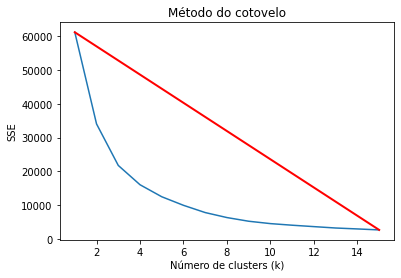

In [127]:
import matplotlib.pyplot as plt

valores_sse = resultados.iloc[0].values # seleciona a primeira linha da tabela
plt.plot(range(1,loop), valores_sse)
plt.plot([1,loop-1], [valores_sse[0], valores_sse[loop-2]], color='red', linestyle='-', linewidth=2) # baseline visual para cálculo do cotovelo 
plt.title("Método do cotovelo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("SSE")
plt.show()

In [128]:
# instalação de bibiotecas necessárias
from kneed import KneeLocator

kl = KneeLocator(range(1, loop), resultados.iloc[0].values, curve="convex", direction="decreasing")
print(f"Valor sugerido para 'k': {kl.elbow}")

Valor sugerido para 'k': 4


---
### Parte II: Algoritmos `k-modes` e `k-prototypes` 


`K-modes` é uma variante do algoritmo `k-means` que contém algumas adaptações específicas para lidar com atributos categóricos. Para tanto, ao invés de usar uma medida de distância, utiliza uma de dissimilaridade que envolve a quantidade de não correspondências de valores. Quanto menor for a dissimilaridade, mais similares são os elementos entre si. Além disso, ao invés de centroides calculados com base em médias ele usa [modas](https://pt.wikipedia.org/wiki/Moda_(estat%C3%ADstica)).

Na mesma linha, o algoritmo `k-prototypes` é um que combina as funcionalidades do `k-modes`, para dados categóricos, com as do `k-means`, para dados contínuos, atuando de forma mista (categóricos e contínuos). 

Para detalhes sobre esses algoritmos, sugere-se a leitura do artigo [Extensions to the k-Means Algorithm for Clustering
Large Data Sets with Categorical Values](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf)

De fato, o cálculo de similaridade utilizado no `k-prototypes` é baseado na abordagem proposta por Gower para medir a distância entre elementos com variáveis de modo misto.

Para saber mais sobre a distância de Gower, sugiro a leitura dos seguintes recursos:

1. [What is Gower’s distance?](https://statisticaloddsandends.wordpress.com/2021/02/23/what-is-gowers-distance/)
2. [Example of calculating the Gower distance](https://jamesmccaffrey.wordpress.com/2020/04/21/example-of-calculating-the-gower-distance/)

Para nossa sorte, existe uma implementação dos algoritmos `k-modes` e `k-prototypes` em Python. Se desejar, [clique aqui para ver um exemplo passo-a-passo do funcionamento do k-modes](https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/).

Eles não fazem parte da biblioteca `scikit-learn` (e por isso não seguem exatamente o mesmo *pipeline* nem os mesmos atributos dos outros algoritmos dessa biblioteca), mas a implementação é bem estável, e pode ser instalado com o comando seguinte:

In [129]:
# instala bibliotecas do algoritmo Kmodes (caso não tenha instalado ou reinicialize o collab)
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Podemos aplicar o `k-modes` ao conjunto de dados original do ENEM, pois ele faz a normalização dos dados internamente:

In [130]:
from kmodes.kmodes import KModes
import pandas as pd
import requests
import io

uri = 'http://raw.githubusercontent.com/lwives/mlp/master/2014.csv'
content = requests.get(uri).content
df_enem = pd.read_csv(io.StringIO(content.decode('utf-8')), sep=";",usecols=["ano_fim_2g", "co_uf_curso", "nu_idade", "tp_sexo", "nt_ger"])

# dados = df_enem.loc[:, ~df_enem.columns.isin(["nu_idade", "nt_ger"])].values # seleciona colunas categórias (exclui idade e média)
dados = df_enem.loc[:, ["co_uf_curso", "tp_sexo"]].values # seleciona só as colunas categórias 

resultados = {} # Dicionário que armazena custo e número de iterações para cada 'k'

# executa o algoritmo para 'k' variando entre 1 e 10
for k in range(1, 11):
    kmodes = KModes(n_clusters=k, init="Huang", n_init=5)
    kmodes.fit(dados)   
    resultados[k] = {"Custo": kmodes.cost_, "Iterações": kmodes.n_iter_} 

resultados = pd.DataFrame.from_dict(resultados)
resultados

,1,2,3,4,5,6,7,8,9,10
Custo,141.0,83.0,54.0,29.0,21.0,10.0,7.0,0.0,0.0,0.0
Iterações,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


Repare que esta biblioteca não usa `SSE` para avaliar os *clusters*. O custo é calculado como a distância de todos os pontos aos seus respectivos centroides (ou medoides). 

Não é possível aplicar `Silhouette` (ao menos a versão da biblioteca existente), pois ela não sabe como processar os dados categóricos para calcular as distâncias. Você pode tentar implementar uma versão apropriada, mas será que o formato de um cluster é uma medida adequada para casos categóricos? 

Vamos incluir as classes identificadas para comparar o resultado com o obtido no `k-means` (células 11 e 12)? 

In [131]:
from kmodes.kmodes import KModes

km = KModes(n_clusters=2, init='Huang', n_init=5) # mesma quantidade de 'k' que usamos no k-means
clusters = km.fit_predict(dados)
df_enem_normalizado['k-modes'] = km.labels_
df_enem_normalizado
# print(km.cluster_centroids_) # imprime os medoides

,co_uf_curso,nu_idade,ano_fim_2g,nt_ger,tp_sexo_F,tp_sexo_M,k-means,k-modes
0,51,23,2007,66.9,0,1,1,0
1,51,24,2007,52.7,0,1,1,0
2,51,22,2009,58.2,1,0,1,1
3,51,24,2007,62.0,1,0,1,1
4,51,23,2008,71.5,1,0,1,1
...,...,...,...,...,...,...,...,...
186,13,25,2007,60.7,1,0,0,1
187,13,23,2008,64.9,1,0,0,1
188,13,22,2009,52.6,1,0,0,1
189,13,22,2009,55.1,0,1,0,0


O código seguinte aplica o `k-prototypes`, agora combinando todas as variáveis:

In [132]:
from kmodes.kprototypes import KPrototypes
import pandas as pd
import requests
import io

uri = 'http://raw.githubusercontent.com/lwives/mlp/master/2014.csv'
content = requests.get(uri).content
# coluna inicia em 0 - as categóricas são a [1] e a [3]
df_enem = pd.read_csv(io.StringIO(content.decode('utf-8')), sep=";",usecols=["ano_fim_2g","co_uf_curso", "nu_idade", "tp_sexo", "nt_ger"])

df_enem['tp_sexo'].replace(['M', 'F'],
                        [0, 1], inplace=True)
print(df_enem)
# df_enem["co_uf_curso"] = df_enem["co_uf_curso"].astype("category")
# df_enem["tp_sexo"] = df_enem["tp_sexo"].astype("category")
print(df_enem.dtypes)


dados = df_enem.values # seleciona todos os atributos
colunas_categoricas = [1,3] # indica quais (índices de) colunas são categóricas

resultados = {} # Dicionário que armazena custo e número de iterações para cada 'k'

# executa o algoritmo para 'k' variando entre 1 e 10
for k in range(1, 11):
    kprototypes = KPrototypes(n_clusters=k, init="Cao", n_init=5, n_jobs=4)
    kprototypes.fit(dados, categorical=colunas_categoricas)     ## ao chamar o algoritmo, indicamos as colunas categóricas
    resultados[k] = {"Custo": kprototypes.cost_, "Iterações": kprototypes.n_iter_} 

resultados = pd.DataFrame.from_dict(resultados)
resultados

     co_uf_curso  nu_idade  tp_sexo  ano_fim_2g  nt_ger
0             51        23        0        2007    66.9
1             51        24        0        2007    52.7
2             51        22        1        2009    58.2
3             51        24        1        2007    62.0
4             51        23        1        2008    71.5
..           ...       ...      ...         ...     ...
186           13        25        1        2007    60.7
187           13        23        1        2008    64.9
188           13        22        1        2009    52.6
189           13        22        0        2009    55.1
190           13        21        1        2009    65.5

[191 rows x 5 columns]
co_uf_curso      int64
nu_idade         int64
tp_sexo          int64
ano_fim_2g       int64
nt_ger         float64
dtype: object


,1,2,3,4,5,6,7,8,9,10
Custo,57709.080487,30558.84453,18255.593156,12499.800843,9117.206978,6910.986175,5461.151011,4339.464085,4315.879079,4327.359623
Iterações,1.000000,6.00000,5.000000,5.000000,7.000000,7.000000,4.000000,6.000000,14.000000,4.000000


---
**Exercício 3**: Aplique o `k-prototypes` no *dataset* seguinte. Considere `k=3`.

<font color="red">Atenção: o `cost_`, nesse algoritmo, é a soma das distâncias dos elementos em relação ao centroide e pode não ser uma medida adequada da estrutura ou composição dos *clusters* (visto que quanto mais *clusters* tivermos, menor será esse valor). Mas muitos estudos utilizem esse valor em conjunto com o método do cotovelo para identificar a melhor quantidade de clusters</font>

In [133]:
import pandas as pd

dados = { 
    'Nome'  : ['José', 'Renato', 'Ana', 'Laura', 'Priscila', 'Rodrigo', 'Paula', 'Leonardo', 'José', 'Carla'],
    'Olhos' : ['castanhos', 'castanhos', 'castanhos', 'azuis', 'verdes', 'castanhos', 'castanhos', 'verdes', 'azuis', 'castanhos'],
    'Genero': ['masculino', 'masculino', 'feminino', 'feminino', 'feminino', 'masculino', 'feminino', 'masculino','masculino', 'feminino'],
    'Idade': [28,30,31,30,27,24,35,40,33,42]
}
df = pd.DataFrame(dados)
df.head() # mostra os 5 primeiros registros carregados no dataframe

,Nome,Olhos,Genero,Idade
0,José,castanhos,masculino,28
1,Renato,castanhos,masculino,30
2,Ana,castanhos,feminino,31
3,Laura,azuis,feminino,30
4,Priscila,verdes,feminino,27


In [134]:
df['Olhos'].replace(['castanhos', 'azuis', 'verdes'],
                           [0, 1, 2], inplace=True)

df['Genero'].replace(['masculino', 'feminino'],
                           [0, 1], inplace=True)

print(df.dtypes)

dados = df.loc[:, ["Olhos", "Genero", "Idade"]].values # seleciona só as colunas categórias 
colunas_categoricas = [1,2] # indica quais (índices de) colunas são categóricas

resultados = {} # Dicionário que armazena custo e número de iterações para cada 'k'

kprototypes = KPrototypes(n_clusters=3, init="Cao", n_init=5, n_jobs=4)
kprototypes.fit(dados, categorical=colunas_categoricas)     ## ao chamar o algoritmo, indicamos as colunas categóricas
resultados = {"Custo": kprototypes.cost_, "Iterações": kprototypes.n_iter_} 


resultados

Nome      object
Olhos      int64
Genero     int64
Idade      int64
dtype: object


{'Custo': 4.6000000000000005, 'Iterações': 1}

---
### Parte III: medindo similaridade com funções próprias

Eventualmente pode ser necessário aplicarmos alguma medida de similaridade específica, mais adequada para o conjunto de dados. 

Existe uma série de medidas que foram criadas ao longo dos anos. Para obter uma explicação ilustrada de algumas delas, sugiro a leitura do seguinte documento: ["17 types of similarity and dissimilarity measures used in data science"](https://towardsdatascience.com/17-types-of-similarity-and-dissimilarity-measures-used-in-data-science-3eb914d2681). E se você deseja utilizá-las, o autor preparou uma biblioteca em Python que as implementa ([clique aqui para acessá-la](https://pydist2.readthedocs.io/en/latest/guide.html)). 

No entanto, se você deseja elaborar alguma abordagem específica para medir a similaridade entre elementos, por exemplo, comparando de alguma maneira diferenciada dois atributos, pode criar sua própria função de similaridade. 


Vamos supor que você queira usar como atributo para comparação uma única dimensão que considere quanto tempo uma pessoa levou para fazer o ENEM após terminar o seu segundo grau.

A linha seguinte cria essa dimensão:

In [135]:
df_enem['intervalo_formacao'] = 2014-df_enem['ano_fim_2g'] 
df_enem.head()

,co_uf_curso,nu_idade,tp_sexo,ano_fim_2g,nt_ger,intervalo_formacao
0,51,23,0,2007,66.9,7
1,51,24,0,2007,52.7,7
2,51,22,1,2009,58.2,5
3,51,24,1,2007,62.0,7
4,51,23,1,2008,71.5,6


Vamos criar uma função que usa essa variável como base para a comparação. 

Para tanto, podemos usar a função `pdist`, que faz uma comparação 2-a-2 (par-a-par) dos elementos, usando uma função de similaridade como base. Para detalhes do seu funcionamento, leia a documentação dela, [clicando aqui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

Você pode utilizar qualquer função sua ou pronta. 

O código seguinte exemplifica o uso de `pdist` e `squareform` com uma função criada por nós para calcular a similaridade entre os elementos, tendo como base o atributo definido na célula acima. Essa função avalia os pares de elementos que são elencados pela função `pdist` e devolve a similaridade do par com base na diferença absoluta simples entre os intervalos de formação.

Os resultados são colocados na lista `similaridades`. Após, a função `squareform()` é chamada. Essa função converte a lista em uma [matriz condensada de similaridades](https://stackoverflow.com/questions/13079563/how-does-condensed-distance-matrix-work-pdist). 

In [136]:
from scipy.spatial.distance import squareform, pdist

def similaridade(u, v):  
  return abs(u[5]-v[5])

similaridades = pdist(df_enem, similaridade)
matriz_similaridade = squareform(similaridades)
matriz_similaridade

array([[0., 0., 2., ..., 2., 2., 2.],
       [0., 0., 2., ..., 2., 2., 2.],
       [2., 2., 0., ..., 0., 0., 0.],
       ...,
       [2., 2., 0., ..., 0., 0., 0.],
       [2., 2., 0., ..., 0., 0., 0.],
       [2., 2., 0., ..., 0., 0., 0.]])

Uma vez que tenhamos criado a matriz, podemos usá-la nos algoritmos de *clusterização*. Basta informar que os dados passados são `precomputed`:

In [137]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(affinity='precomputed', n_clusters=2, linkage='complete').fit(matriz_similaridade)
print(model.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


A seguir você encontra outro exemplo de um *dataset* sendo processado por uma função específica de similaridade. Se desejar, pode usar uma função pronta (há várias na biblioteca `scikit-learn` - leia [funções prontas](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). 

In [138]:
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform

def similaridade(u, v):
    return 1/(1+euclidean(u,v))

df = pd.DataFrame.from_dict({"d1":[1.1,3.3,20.1],"d2":[1.3,3.1,20.5],"d3":[2.1,3.9,21.5],"d4":[1.5,2.8,19.9]})
df.index = ["e1","e2","e3"]

distancias = pdist(df, similaridade)
matriz = pd.DataFrame(squareform(distancias), columns=df.index, index=df.index)

In [139]:
df

,d1,d2,d3,d4
e1,1.1,1.3,2.1,1.5
e2,3.3,3.1,3.9,2.8
e3,20.1,20.5,21.5,19.9


In [140]:
matriz

,e1,e2,e3
e1,0.000000,0.217064,0.025636
e2,0.217064,0.000000,0.028205
e3,0.025636,0.028205,0.000000


---
**DESAFIO**: Crie ou escolha um *dataset* e aplique uma função de similaridade apropriada, criada por você (preferencialmente) ou [existente na biblioteca `sci-kit-learn`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Como no exemplo anterior, use `pdist` e `squareform` para criar a matriz de similaridades. Após, aplique-a a algum algoritmo de clusterização e mostre o resultado.